#  Machine Learning - Mini Project II

## Learning Algorithm: Classifier

Created on March 10, 2019 by Diogo Cosin <d.ayresdeoliveira@jacobs-university.de> and Ralph Florent <r.florent@jacobs-university.de>.

## Description
Train a classifier for the Digits dataset by implementing a full processing pipeline from feature extraction to (linear) classifier training, attempting to squeeze performance out of the classifier using cross-validation and regularization techniques.

## Summary
The script below is intended to... 

WIP

Note: The algorithm is tested on the OCR datasets from the `DigitsBasicsRoutine.zip`, which was provided by Professor Dr. H. Jaeger, Machine Learning Professor at [Jacobs University Bremen](https://www.jacobs-university.de).

In [61]:
""" Learning Algorithm: Classifier """

# -*- coding: utf-8 -*-
# 
# Created on April 01, 2019
# Authors: 
#        Diogo Cosin <d.ayresdeoliveira@jacobs-university.de>,
#        Ralph Florent <r.florent@jacobs-university.de>


# Import relevant libraries
import sys
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
from timeit import default_timer as timer
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

sys.path.append('./assets/')
from miniprojectone import get_data_points, k_means, get_codebooks, assign_randomly

# START: Scripts
TOTAL_DIGIT_CLASSES = 10

# Matplotlib Deafault Parameters
pylab.rcParams['figure.figsize'] = (12, 7)
pylab.rcParams['axes.titlesize'] = 18.0
pylab.rcParams['xtick.labelsize'] = 16.0
pylab.rcParams['ytick.labelsize'] = 16.0
pylab.rcParams['legend.fontsize'] = 17.0
pylab.rcParams['axes.labelsize'] = 17.0
pylab.rcParams['mathtext.fontset'] = 'stix'
pylab.rcParams['font.family'] = 'STIXGeneral'

# Helper functions
# The set of helpers defined below ease up the procedure for creating
# the data processing pipeline.

def load_data(one_hot_encoding=None):
    """ Load the full dataset with or without labelling the output
    
    This function relies on the existing `get_data_points()` function
    from `miniprojectone.py` to read the data from the text file
    `mfeat.info`.
    By specifying the `one_hot_encoding` boolean parameter, the data
    is loaded with injected labels that is numbered from 1-10,
    if False, and 10-dimensional one-hot encoded values.
    
    Read more in the :ref:`../assets/miniprojectone.py`.
        
    Parameters
    ----------
    one_hot_encoding: bool, default = None
        determine whether labeling the output should be used or not,
        and if yes, labeled as numbered values or one-hot encoding 
        values.

    Returns
    -------
    dataframe: array-like (N_samples, m_features)
        the entire digit dataset of 2000 observations by 240 and 
        injected labels.
    """
    dataframe = get_data_points() # load non-labeled data frame
    
    if one_hot_encoding is None:
        return dataframe
    return inject_label(dataframe, one_hot_encoding) # load labeled data frame 


def one_hot_encode(ith, k=TOTAL_DIGIT_CLASSES):
    """ Apply one-hot encoding technique for a k-dimensional vector
        
    This function is intended to work like a lightweight version 
    of one-hot-encoder. It is adapted to this specific situation:
    a vector of k-dimensional zeros and one at the ith position.

    Parameters
    ----------
    ith: int
        the ith position of the one-of-K discrete label. The `ith`
        position must be expressed in a human readable way, so
        to solve indexing ambiguity with array. That is, array
        indices go from 0 to the array's length - 1, but here `ith`
        goes from 1 to array's length. For instance, indexing the 
        3rd position of an array A is, A[2], whereas the ith position
        of the encoded vector is 3.

    k: int, default = 10
        number of k-classes for the encoding vector

    Returns
    -------
    encoded: 1D-array
        vector with zeros and one in the ith position
    """
    if ith > k:
        ith = k # avoid out of bound exception
        
    index = ith - 1 # index it as array
    encoded = np.zeros(k) # k-sized of zero vectors
    encoded[index] = 1 # modify the position
    return encoded


def inject_label(dataset, one_hot_encoding=False):
    """ Inject numbered or one-hot encoded class labels into a dataset
    
    It should be noted that, due to special requirements of the project,
    the class labels for the digits 1-9, are mapped to 1-9 numbers, and 0 
    to 10.
    
    Parameters
    ----------
    dataset: 2D-array shape: (N_samples, m_features)
        a dataset of 10-dimensional features 

    one_hot_encoding: bool
        determine whether labeling the output as numbered values or 
        one-hot encoding values.

    Returns
    -------
    dataframe: 2D-array shape (N_samples, m_features)
        the m-feature augmented dataset.
    """
    dataframe, k_class = [], TOTAL_DIGIT_CLASSES
    digits = np.array_split(dataset, k_class) # split into 10 arrays
    for i in range(k_class):
        digit =  digits[i]
        if i == 0: 
            i = 10 # define "0" as class 10
        encoded = one_hot_encode(i) if one_hot_encoding else i
        
        # insert this encoded label to each point
        for point in digit:
            dataframe.append( np.insert(point, len(point), encoded) )
            
    return np.array(dataframe) 


def split_data(dataframe):
    """ Split data frame into training and testing data
    
    The splitting logic is simple here since we know the data
    structure of the data frame. The function simply assembles the
    first 100 samples of each digit of 10 as training data, and 
    the rest as testing data.
    
    Parameters
    ----------
    dataframe: array-like (N_samples, m_features)
        2000 digit patterns by k-features

    Returns
    -------
    splits: list, shape(2, 2D-array data)
        list containing array of training and array of testing data
    """
    nbr_digits = 10
    range_size = 100
    digits = np.array_split(dataframe, nbr_digits)
    
    train_data, test_data = [], []

    # `extend()` iterates over the array and appends each element to the list
    for digit in digits:
        train_data.extend(digit[:range_size])
        test_data.extend(digit[range_size:])
    
    return [np.array(train_data), np.array(test_data)]


def select_features(dataset, codebooks):
    """ Apply Euclidean distance between k-means centroid and each point
    to extract k features.
    
    The feature extraction happens by calculating the Euclidean distance 
    between the data points xi and the codebook vectors ci and assigning 
    each distance as a new feature.
    
    Parameters
    ----------
    dataset: 2D-array shape: (N_samples, m_features)

    codebooks: 2D-array shape: (k_codebooks, m_features)
        K-sized applied K-means-clustering centroids

    Returns
    -------
    features: 2D-array shape (N_samples, k_features + 1)
        the extracted features with an additional padding value.
    """
    features = []
    
    # transfrom xi -> fi by reducing dimensionality from N to k features
    for point in dataset:
        # compute distance between data point and centroid 
        feature = [np.linalg.norm(point - c) for c in codebooks]
        feature.append(1) # padded with a trailing 1 
        features.append(np.array(feature))
    
    return np.array(features)


def get_pca_components(X, nbr_pcs=10):
    """ Apply PCA to X.
    
    Parameters
    ----------
    X: 2D-array shape: (N_samples, n_columns)
    
    Returns
    -------
    U: 2D-array shape: (n_columns, m_components)
    X_bar: 2D-array shape: (N_samples, n_columns)
    """
    
    N, n_cols = X.shape
    X_transpose = X.T
    X_bar_transpose = X_transpose - np.mean(X_transpose, axis=1).reshape(n_cols, 1) # reshape to allow the subtraction
    
    C = (1./N)*X_bar_transpose@X_bar_transpose.T
    U, S, Vh = np.linalg.svd(C)
    
    X_bar = X_bar_transpose.T
    
    return U[:, :nbr_pcs], X_bar


def project_to_pca_comps(X_bar, U):
    """Project the centered X_bar matrix to the principal components defined by U.
    
    Parameters
    ----------
    X_bar: 2D-array shape: (N_samples, n_columns)
    U: 2D-array shape: (n_columns, m_components)
    
    Returns
    -------
    X_reduced: 2D-array shape: (N_samples, m_components)
    """
    X_reduced = (U.T@X_bar.T).T
    X_reduced = np.insert(X_reduced, X_reduced.shape[1], 1, axis=1) # append bias 1 as the last feature
    return X_reduced


def select_min_dist_cluster(dataset):
    """Transform each datapoint to the cluster index which the distance between is minimal.
    
    Parameters
    ----------
    dataset: 2D-array shape: (N_samples, m_features)
    
    Returns
    -------
    features: 2d-array shape (N_samples, 2)
        the extracted cluster index with an additional padding value.
    """
    features = np.argmin(dataset[:, :-1], axis=1) # select closest cluster disregarding the bias feature
    features_size = features.shape[0]
    features = features.reshape(features_size, 1)
    features = np.insert(features, 1, 1, axis=1) # append the bias feature
    
    return features


def compute_linreg(Phi, Zi, alpha=0.0):
    """ Compute the weights of the matrix Wopt that solves the linear regression
    
    Data: Given m-dimensional feature vectors (fi) and k-dimensional target vectors (zi)
    Result: a kxm-dimensional weight matrix Wopt that solves the linear regression
    
    1) Sort the feature vectors row-wise into an Nxm matrix (Phi) and the targets into an
    Nxk matrix (Z)
    2) Compute the pseudo inverse of Phi x Zi as the Wopt transposed.
    
    The pseudo-inverse of a matrix A, denoted A^+, is defined as: “the matrix that ‘solves’ 
    [the least-squares problem] Ax = b,” i.e., if x is said solution, then A^+ is 
    that matrix such that x = A^+b.
    
    Read more in the:ref: 
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.identity.html
        
    Parameters
    ----------
    Phi: 2D-array shape: (N_samples, m_features)
        the inputs (Xi) of the data sample
    
    Zi: 2D-array shape: (N_samples, k_features)
        the outputs (Yi) of the data sample

    alpha: float, default = 0.0
        the ridge factor 

    Returns
    -------
    Wopt: 2D-array shape (k_values, m_values)
        the optimal weight matrix that solves the linear regression
    """
    # compute rigde regression factor
    ridge_factor = alpha * np.identity(Phi.shape[1]) # Imxm identity matrix
    # compute pseudo inverse of Phi x Zi
    Wopt = np.linalg.inv(np.dot(Phi.T, Phi) + ridge_factor).dot(Phi.T).dot(Zi)
    return Wopt.T


def check_accuracy(Y_ground, Y_pred):
    """ Compute model accuracy by assessing the results (predicted) 
    against the ground truth values
    
    Parameters
    ----------
    Y_ground: 2D-array shape: (N_values, k_values)
        the true values the class labels
    
    Y_pred: 2D-array shape: (N_values, k_values)
        the predicted values using the trained model

    Returns
    -------
    accuracy: float
        the accuracy rate between the true and predicted values
    """
    ground_labels = np.argmax(Y_ground, axis=1) # N-dimensional vector with the ground labels
    predicted_labels = np.argmax(Y_pred, axis=1) # N-dimensional vector with the highest probability position
    
    correct_classifications = sum(predicted_labels == ground_labels)
    accuracy = float(correct_classifications)/Y_ground.shape[0]
    
    return accuracy


def check_MSE(Y_ground, Y_pred):
    """ Compute the Mean Squared Error(MSE) by assessing the results 
    (predicted) against the ground truth
    
    Parameters
    ----------
    Y_ground: 2D-array shape: (N_values, k_values)
        the true values the class labels
    
    Y_pred: 2D-array shape: (N_values, k_values)
        the predicted values using the trained model

    Returns
    -------
    MSE: float
        the mean squared error given the true and predicted values
    """
    Y_norm = np.linalg.norm(Y_ground - Y_pred, axis=1) # N-dimensional vector with the norms
    MSE = np.square(Y_norm).mean()
    
    return MSE


def predict_hypothesis_matrix(model, X):
    """ Compute the hypothesis matrix using the linear combination of 
    the optimal weights matrix (model) and the training inputs (Xi)
    
    Parameters
    ----------
    model: sparse matrix (k_values, m_values)
        the optimal weight matrix that solves the linear regression
    
    X: 2D-array shape (N_values, m_values)
        the training inputs (Xi) of the data sample

    Returns
    -------
    hypothesis_matrix: sparse matrix (N_values, k_values)
        the matrix form of the predicted values for the given X
    """
    hypothesis_matrix = model@X.T # result in a k by N matrix
    return hypothesis_matrix.T # return N by k hypothesis matrix


def k_fold_cv(dataset, nbr_folds=5, m=10, alpha=0.0, feature_extraction="k-means distances"):
    """ Compute the k-fold cross-validation over a given dataset
    
    Parameters
    ----------
    dataset: 2D-array shape (N_samples, m_features)
        the data sample containing both input patterns and output labels
    
    nbr_folds: int, default = 5
        the number of folds for the cross-validation
        
    m: int, default = 10
        the number features of to extract
        
    alpha: float, default = 0.0
        the ridge factor for the ridge regression computation
    
    use_cluster_idx: default = False
        when set to True, use the closest cluster index as the feature

    Returns
    -------
    cv_accuracy_train: float
        the overall accuracy rate for the folds on the training data
        
    cv_accuracy_test: float
        the overall accuracy rate for the folds on the testing data
    
    cv_MSE_train: float
        the overall mean squared error for the folds on the training data
        
    cv_MSE_test: float
        the overall mean squared error for the folds on the test data
    """
    # copy the data to avoid affecting reference
    data = dataset.copy()
    
    # divide into k-folds
    folds = assign_randomly(data, nbr_folds)
    
    accuracy_train, accuracy_test = [], []
    MSE_train, MSE_test = [], []
    
    # train models for the folds
    for i in range(nbr_folds):
        
        # distribute into train and test data
        test_data, train_data = folds[i], []
        for j in range(nbr_folds):
            if i != j:
                train_data.extend(folds[j])
        
        train_data = np.array(train_data)
        test_data = np.array(test_data)
                
        # separate X (inputs) and Y (labels) for the training and testing data
        x_train, y_train = train_data[:, :-TOTAL_DIGIT_CLASSES], train_data[:, -TOTAL_DIGIT_CLASSES:]
        x_test, y_test = test_data[:, :-TOTAL_DIGIT_CLASSES], test_data[:, -TOTAL_DIGIT_CLASSES:]
        
        # Dimensionality reduction
        if feature_extraction == "k-means distances":
            start = timer()
            clusters = k_means(x_train, m)
            codebooks = get_codebooks(clusters)
            end = timer()
            print("--- K-means elapsed time: {:1.10f}".format(end - start))
            start = timer()
            x_train = select_features(x_train, codebooks)
            x_test = select_features(x_test, codebooks)
        elif feature_extraction == "pca":
            start = timer()
            components, x_bar = get_pca_components(x_train, m)
            end = timer()
            print("--- K-means elapsed time: {:1.10f}".format(end - start))
            start = timer()
            x_train = project_to_pca_comps(x_train, components)
            x_test = project_to_pca_comps(x_test, components)
            print("X train shape: {}".format(x_train.shape))
            print("X test shape: {}".format(x_test.shape))
            

#         if use_cluster_idx:
#             x_train = select_min_dist_cluster(x_train)
#             x_test = select_min_dist_cluster(x_test)
        end = timer()
        print("--- Feature extraction elapsed time: {:1.10f}".format(end - start))
        
        # compute models for training data
        model = compute_linreg(x_train, y_train, alpha)
        
        # prediction on training and testing data
        pred_train = predict_hypothesis_matrix(model, x_train)
        pred_test = predict_hypothesis_matrix(model, x_test) 
        
        # assess accuracy
        _acc_train = check_accuracy(pred_train, y_train)
        _acc_test  = check_accuracy(pred_test, y_test)
        
        accuracy_train.append(_acc_train)
        accuracy_test.append(_acc_test)

        # assesss MSE
        _MSE_train = check_MSE(pred_train, y_train)
        _MSE_test = check_MSE(pred_test, y_test)
        
        MSE_train.append(_MSE_train)
        MSE_test.append(_MSE_test)
        
    cv_accuracy_train = np.mean(accuracy_train)
    cv_accuracy_test = np.mean(accuracy_test)
    cv_MSE_train = np.mean(MSE_train)
    cv_MSE_test = np.mean(MSE_test)
        
    return cv_accuracy_train, cv_accuracy_test, cv_MSE_train, cv_MSE_test

## Loading training and testing data
The `load_data` function helps framing the data with numbered or one-hot encoding class labels to build an in-memory data frame. 

Given this data frame, let's load the first 100 digit-patterns as training data and the second 100 as testing data, for a specific digit, that is, we divide the original dataset into two partitions, training and testing, each containing 1000 observations.

In [11]:
dataframe = load_data(one_hot_encoding=True)

# Distribute dataframe into training and testing data
training_data, testing_data = split_data(dataframe)

print(dataframe.shape, training_data.shape, testing_data.shape)

(2000, 250) (1000, 250) (1000, 250)


## Cross-validation with *K-means* Feature Extraction

### Seeking the Optimal Number of Clusters *K*

We now try different combinations of alpha and number of K-means clusters, checking the metrics for each combination. The objective here is to optimize the classifier improving, this way, the performance metrics. In this scenario, we constantly set $\alpha$ to zero.

The results are stored in the dictionary `grid_search_metrics`.

In [15]:
alpha_list = [0.0]
k_list = [2, 5, 10, 20, 50, 100, 200, 400, 800]

In [49]:
k_fold = 10 

# define dictionary where the result for each K iteration is stores
grid_search_metrics = {}
grid_search_metrics["alpha"] = []
grid_search_metrics["K"] = []
grid_search_metrics["cv_acc_train"] = []
grid_search_metrics["cv_acc_test"] = []
grid_search_metrics["cv_MSE_train"] = []
grid_search_metrics["cv_MSE_test"] = []

for k in k_list:
    print("=> Processing k={}".format(k))    
    for alpha in alpha_list:
        grid_search_metrics["alpha"].append(alpha)
        grid_search_metrics["K"].append(k)
        
        # execute the cross-validation
        cv_results = k_fold_cv(training_data, k_fold, k, alpha)
        
        # unpack the results
        cv_accuracy_train, cv_accuracy_test = cv_results[0], cv_results[1]
        cv_MSE_train, cv_MSE_test = cv_results[2], cv_results[3]
        
        # save the results
        grid_search_metrics["cv_acc_train"].append(cv_accuracy_train)
        grid_search_metrics["cv_acc_test"].append(cv_accuracy_test)
        grid_search_metrics["cv_MSE_train"].append(cv_MSE_train)
        grid_search_metrics["cv_MSE_test"].append(cv_MSE_test)

=> Processing k=200


KeyboardInterrupt: 

In [52]:
alpha_list = [0.0]
pc_list = [2, 10, 25, 50, 100, 200, 239]

### Visualizang the Results for DIfferent Number of Clusters *K*

First, we load the cross-validation results into a pandas Dataframe to make the results interpretability easier.

In [17]:
cv_k_results = pd.DataFrame(grid_search_metrics)
cv_k_results

,alpha,K,cv_acc_train,cv_acc_test,cv_MSE_train,cv_MSE_test
0,0.0,2,0.367667,0.360,0.767387,0.773221
1,0.0,5,0.669333,0.650,0.606619,0.616916
2,0.0,10,0.827222,0.818,0.393061,0.413972
3,0.0,20,0.944111,0.937,0.231644,0.252433
4,0.0,50,0.968889,0.958,0.156782,0.187713
5,0.0,100,0.978333,0.969,0.122546,0.159196
6,0.0,200,0.986556,0.973,0.085104,0.134735
7,0.0,400,0.997222,0.979,0.048077,0.119104
8,0.0,800,0.999889,0.980,0.006133,0.105291


Now we plot the results for different number of clusters *K*.

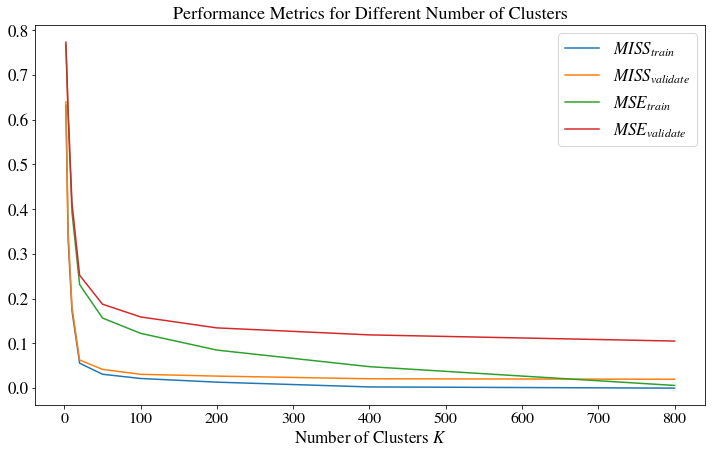

In [20]:
K_values = cv_k_results["K"]
plt.plot(K_values, 1-cv_k_results["cv_acc_train"], label=r"$MISS_{train}$")
plt.plot(K_values, 1-cv_k_results["cv_acc_test"], label=r"$MISS_{validate}$")
plt.plot(K_values, cv_k_results["cv_MSE_train"], label=r"$MSE_{train}$")
plt.plot(K_values, cv_k_results["cv_MSE_test"], label=r"$MSE_{validate}$")
plt.title("Performance Metrics for Different Number of Clusters")
plt.xlabel(r"Number of Clusters $K$")
plt.legend();

### Seeking the Optimal Ridge factor $\alpha$

Now, we apply the same cross-validation strategy to the paramter *alpha*. In this case, we constantly set *K* to 50 clusters.

In [21]:
alpha_list = [0.0, 0.5, 1, 10, 25, 50, 100, 250, 500, 1000]
k_list = [50]

In [22]:
k_fold = 10 

# define dictionary where the result for each K iteration is stores
grid_search_metrics = {}
grid_search_metrics["alpha"] = []
grid_search_metrics["K"] = []
grid_search_metrics["cv_acc_train"] = []
grid_search_metrics["cv_acc_test"] = []
grid_search_metrics["cv_MSE_train"] = []
grid_search_metrics["cv_MSE_test"] = []

for k in k_list:
    print("=> Processing k={}".format(k))    
    for alpha in alpha_list:
        grid_search_metrics["alpha"].append(alpha)
        grid_search_metrics["K"].append(k)
        
        # execute the cross-validation
        cv_results = k_fold_cv(training_data, k_fold, k, alpha)
        
        # unpack the results
        cv_accuracy_train, cv_accuracy_test = cv_results[0], cv_results[1]
        cv_MSE_train, cv_MSE_test = cv_results[2], cv_results[3]
        
        # save the results
        grid_search_metrics["cv_acc_train"].append(cv_accuracy_train)
        grid_search_metrics["cv_acc_test"].append(cv_accuracy_test)
        grid_search_metrics["cv_MSE_train"].append(cv_MSE_train)
        grid_search_metrics["cv_MSE_test"].append(cv_MSE_test)

=> Processing k=50
--- K-means elapsed time: 19.2797571230
--- Feature extraction elapsed time: 0.4040074450
--- K-means elapsed time: 22.3192643400
--- Feature extraction elapsed time: 0.4409317750
--- K-means elapsed time: 19.9765975410
--- Feature extraction elapsed time: 0.4389031010
--- K-means elapsed time: 27.4580101710
--- Feature extraction elapsed time: 0.4275796810
--- K-means elapsed time: 24.4830128610
--- Feature extraction elapsed time: 0.4732880000
--- K-means elapsed time: 24.7498036430
--- Feature extraction elapsed time: 0.4610466940
--- K-means elapsed time: 28.2220445240
--- Feature extraction elapsed time: 0.4271009600
--- K-means elapsed time: 21.3401816850
--- Feature extraction elapsed time: 0.4500785080
--- K-means elapsed time: 21.5284031730
--- Feature extraction elapsed time: 0.5060090350
--- K-means elapsed time: 20.2092750560
--- Feature extraction elapsed time: 0.4459987060
--- K-means elapsed time: 29.2132990750
--- Feature extraction elapsed time: 0.52

--- K-means elapsed time: 22.1263693770
--- Feature extraction elapsed time: 0.4394832930
--- K-means elapsed time: 27.1699460700
--- Feature extraction elapsed time: 0.4315663260
--- K-means elapsed time: 24.1587687030
--- Feature extraction elapsed time: 0.4412818970
--- K-means elapsed time: 28.1181625410
--- Feature extraction elapsed time: 0.4320912650
--- K-means elapsed time: 15.6844288990
--- Feature extraction elapsed time: 0.4189511560
--- K-means elapsed time: 34.3655700540
--- Feature extraction elapsed time: 0.4200576540
--- K-means elapsed time: 19.1058907110
--- Feature extraction elapsed time: 0.4480463510
--- K-means elapsed time: 18.2913048640
--- Feature extraction elapsed time: 0.4224314210
--- K-means elapsed time: 28.8664035830
--- Feature extraction elapsed time: 0.4235380820


### Visualizang the Results for DIfferent $\alpha$ Values

Again, we load the cross-validation results into a pandas Dataframe to make the results interpretability easier.

In [23]:
cv_alpha_results = pd.DataFrame(grid_search_metrics)
cv_alpha_results

,alpha,K,cv_acc_train,cv_acc_test,cv_MSE_train,cv_MSE_test
0,0.0,50,0.967889,0.959,0.157747,0.186756
1,0.5,50,0.969778,0.965,0.159664,0.185027
2,1.0,50,0.968222,0.958,0.160603,0.187678
3,10.0,50,0.968556,0.964,0.158774,0.186591
4,25.0,50,0.967333,0.963,0.159901,0.187562
5,50.0,50,0.969000,0.956,0.159010,0.192911
6,100.0,50,0.969333,0.956,0.159381,0.189301
7,250.0,50,0.968556,0.960,0.162904,0.190903
8,500.0,50,0.963111,0.961,0.173697,0.201834
9,1000.0,50,0.962000,0.950,0.186349,0.216823


Now we plot the results for different values of $\alpha$.

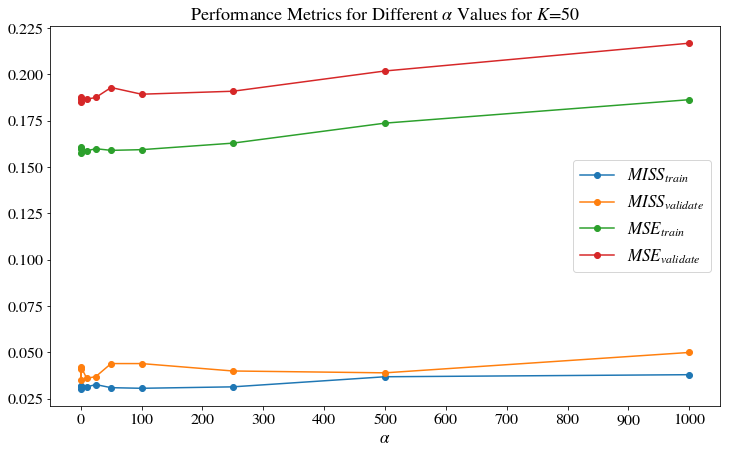

In [99]:
alpha_values = cv_alpha_results["alpha"]
plt.plot(alpha_values, 1-cv_alpha_results["cv_acc_train"], marker="o", label=r"$MISS_{train}$")
plt.plot(alpha_values, 1-cv_alpha_results["cv_acc_test"], marker="o", label=r"$MISS_{validate}$")
plt.plot(alpha_values, cv_alpha_results["cv_MSE_train"], marker="o", label=r"$MSE_{train}$")
plt.plot(alpha_values, cv_alpha_results["cv_MSE_test"], marker="o", label=r"$MSE_{validate}$")
plt.title(r"Performance Metrics for Different $\alpha$ Values for $K$=50")
plt.xlabel(r"$\alpha$")
plt.xticks(range(0, 1001, 100))
plt.legend();

## Cross-validation with PCA Feature Extraction

### Seeking the Optimal Number of Principal Components

In [81]:
alpha_list = [0.0]
pc_list = [2, 10, 20, 40, 50, 60, 80, 100, 125, 150, 175, 200, 239]

In [82]:
k_fold = 10 

# define dictionary where the result for each K iteration is stores
grid_search_metrics = {}
grid_search_metrics["alpha"] = []
grid_search_metrics["PC"] = []
grid_search_metrics["cv_acc_train"] = []
grid_search_metrics["cv_acc_test"] = []
grid_search_metrics["cv_MSE_train"] = []
grid_search_metrics["cv_MSE_test"] = []

for pc in pc_list:
    print("=> Processing k={}".format(k))    
    for alpha in alpha_list:
        grid_search_metrics["alpha"].append(alpha)
        grid_search_metrics["PC"].append(pc)
        
        # execute the cross-validation
        cv_results = k_fold_cv(training_data, k_fold, pc, alpha, "pca")
        
        # unpack the results
        cv_accuracy_train, cv_accuracy_test = cv_results[0], cv_results[1]
        cv_MSE_train, cv_MSE_test = cv_results[2], cv_results[3]
        
        # save the results
        grid_search_metrics["cv_acc_train"].append(cv_accuracy_train)
        grid_search_metrics["cv_acc_test"].append(cv_accuracy_test)
        grid_search_metrics["cv_MSE_train"].append(cv_MSE_train)
        grid_search_metrics["cv_MSE_test"].append(cv_MSE_test)

=> Processing k=50
--- K-means elapsed time: 0.0432171490
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0018016630
--- K-means elapsed time: 0.0305982580
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0018062540
--- K-means elapsed time: 0.0309973490
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0020800020
--- K-means elapsed time: 0.0264971400
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0019157560
--- K-means elapsed time: 0.0293692000
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0026439810
--- K-means elapsed time: 0.0309438760
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0018896340
--- K-means elapsed time: 0.0276846790
X train shape: (900, 2)
X test shape: (100, 2)
--- Feature extraction elapsed time: 0.0018904970
--- K-means elapsed time: 0.0

--- K-means elapsed time: 0.0475252850
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0041713170
--- K-means elapsed time: 0.0350899210
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0029871920
--- K-means elapsed time: 0.0323284500
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0029363990
--- K-means elapsed time: 0.0275924510
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0031114520
--- K-means elapsed time: 0.0278904240
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0032663980
--- K-means elapsed time: 0.0351354870
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0040133710
--- K-means elapsed time: 0.0266077110
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0032486680
--- K-means elapsed time: 0.026612

=> Processing k=50
--- K-means elapsed time: 0.0295103110
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0084213330
--- K-means elapsed time: 0.0277204750
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0047283520
--- K-means elapsed time: 0.0271158170
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0050880540
--- K-means elapsed time: 0.0266385750
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0051687380
--- K-means elapsed time: 0.0313443920
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0050059560
--- K-means elapsed time: 0.0266383810
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0051163090
--- K-means elapsed time: 0.0267970210
X train shape: (900, 239)
X test shape: (100, 239)
--- Feature extraction elapsed time: 0.0050983070
-

In [83]:
cv_pc_results = pd.DataFrame(grid_search_metrics)
cv_pc_results

,alpha,PC,cv_acc_train,cv_acc_test,cv_MSE_train,cv_MSE_test
0,0.0,2,0.365111,0.356,0.836181,0.839118
1,0.0,10,0.841000,0.829,0.521497,0.535045
2,0.0,20,0.920556,0.904,0.382183,0.401805
3,0.0,40,0.944444,0.926,0.314818,0.346266
4,0.0,50,0.944778,0.922,0.304419,0.344324
5,0.0,60,0.952111,0.928,0.295735,0.340446
6,0.0,80,0.957556,0.927,0.279795,0.340578
7,0.0,100,0.958556,0.929,0.269948,0.339192
8,0.0,125,0.964444,0.925,0.258100,0.348397
9,0.0,150,0.966889,0.919,0.247287,0.356946


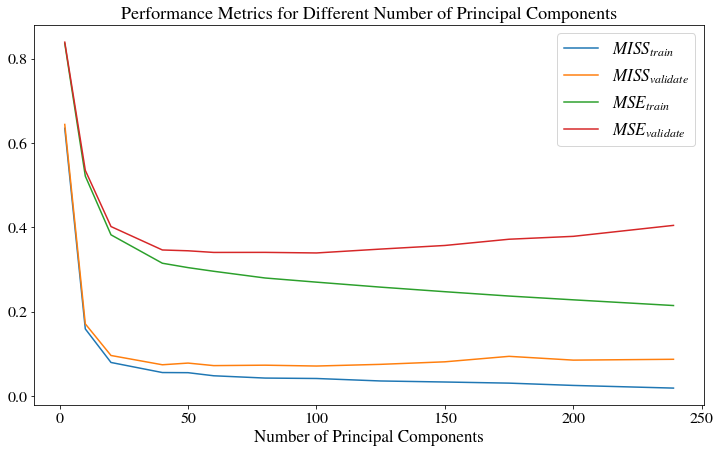

In [84]:
pc_values = cv_pc_results["PC"]
plt.plot(pc_values, 1-cv_pc_results["cv_acc_train"], label=r"$MISS_{train}$")
plt.plot(pc_values, 1-cv_pc_results["cv_acc_test"], label=r"$MISS_{validate}$")
plt.plot(pc_values, cv_pc_results["cv_MSE_train"], label=r"$MSE_{train}$")
plt.plot(pc_values, cv_pc_results["cv_MSE_test"], label=r"$MSE_{validate}$")
plt.title("Performance Metrics for Different Number of Principal Components")
plt.xlabel(r"Number of Principal Components")
plt.legend();

We notice that, the model is overfitting for a higher number of principal components, given that the $MISS_{train}$ keeps monotically decreasing, while $MISS_{test}$ presents the *U-shape*. Thus, setting the number of components to 80 (the best $MISS_{test}$ score), let's seek the optimal $\alpha$ value.

### Seeking the Optimal $\alpha$ Value

In [85]:
alpha_list = [0.0, 0.5, 1, 10, 25, 50, 100, 250, 500, 1000]
pc_list = [80]

In [86]:
k_fold = 10 

# define dictionary where the result for each K iteration is stores
grid_search_metrics = {}
grid_search_metrics["alpha"] = []
grid_search_metrics["PC"] = []
grid_search_metrics["cv_acc_train"] = []
grid_search_metrics["cv_acc_test"] = []
grid_search_metrics["cv_MSE_train"] = []
grid_search_metrics["cv_MSE_test"] = []

for pc in pc_list:
    print("=> Processing pc={}".format(pc))    
    for alpha in alpha_list:
        grid_search_metrics["alpha"].append(alpha)
        grid_search_metrics["PC"].append(pc)
        
        # execute the cross-validation
        cv_results = k_fold_cv(training_data, k_fold, pc, alpha, "pca")
        
        # unpack the results
        cv_accuracy_train, cv_accuracy_test = cv_results[0], cv_results[1]
        cv_MSE_train, cv_MSE_test = cv_results[2], cv_results[3]
        
        # save the results
        grid_search_metrics["cv_acc_train"].append(cv_accuracy_train)
        grid_search_metrics["cv_acc_test"].append(cv_accuracy_test)
        grid_search_metrics["cv_MSE_train"].append(cv_MSE_train)
        grid_search_metrics["cv_MSE_test"].append(cv_MSE_test)

=> Processing pc=80
--- K-means elapsed time: 0.0419097110
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0034279470
--- K-means elapsed time: 0.0310957740
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0027106290
--- K-means elapsed time: 0.0276531230
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0030212410
--- K-means elapsed time: 0.0265247370
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0033632300
--- K-means elapsed time: 0.0281104640
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0035930230
--- K-means elapsed time: 0.0319007890
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0029800610
--- K-means elapsed time: 0.0268488190
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0031438010
--- K-means el

--- K-means elapsed time: 0.0288906080
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0035895430
--- K-means elapsed time: 0.0426587350
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0060099340
--- K-means elapsed time: 0.0351916100
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0073437760
--- K-means elapsed time: 0.0368982770
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0049793400
--- K-means elapsed time: 0.0396223650
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0040761890
--- K-means elapsed time: 0.0295904160
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0031894480
--- K-means elapsed time: 0.0266143640
X train shape: (900, 80)
X test shape: (100, 80)
--- Feature extraction elapsed time: 0.0030057060
--- K-means elapsed time: 0.026982

### Visualizang the Results for DIfferent $\alpha$ Values

In [102]:
cv_pc_results = pd.DataFrame(grid_search_metrics)
cv_pc_results

,alpha,PC,cv_acc_train,cv_acc_test,cv_MSE_train,cv_MSE_test
0,0.0,80,0.958667,0.928,0.279800,0.339638
1,0.5,80,0.958333,0.927,0.280011,0.337632
2,1.0,80,0.957778,0.925,0.279984,0.339234
3,10.0,80,0.958222,0.928,0.280020,0.338284
4,25.0,80,0.958556,0.929,0.279950,0.339941
5,50.0,80,0.958667,0.930,0.280084,0.335431
6,100.0,80,0.958667,0.926,0.279933,0.339405
7,250.0,80,0.956667,0.925,0.280488,0.335124
8,500.0,80,0.956889,0.928,0.281786,0.334209
9,1000.0,80,0.955000,0.923,0.285533,0.332705


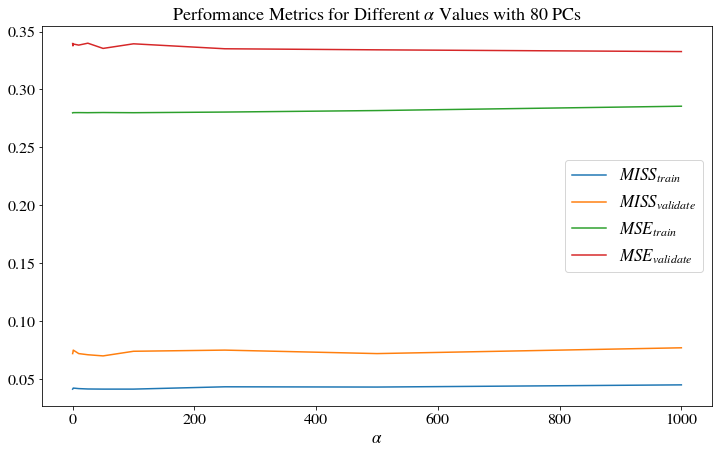

In [100]:
alpha_values = cv_pc_results["alpha"]
plt.plot(alpha_values, 1-cv_pc_results["cv_acc_train"], label=r"$MISS_{train}$")
plt.plot(alpha_values, 1-cv_pc_results["cv_acc_test"], label=r"$MISS_{validate}$")
plt.plot(alpha_values, cv_pc_results["cv_MSE_train"], label=r"$MSE_{train}$")
plt.plot(alpha_values, cv_pc_results["cv_MSE_test"], label=r"$MSE_{validate}$")
plt.title(r"Performance Metrics for Different $\alpha$ Values with 80 PCs")
plt.xlabel(r"$\alpha$")
plt.legend();

## Assessing Model Perfomance on the Testing Data

Now that the best model configuration was defined by the previous cross-validation, we train this model configuration on the full training data and assess its performance on the Testing Data, so far, a completely untouched dataset.

In [26]:
nbr_clusters = 100

X_train = training_data[:, :-TOTAL_DIGIT_CLASSES]
Z_train = training_data[:, -TOTAL_DIGIT_CLASSES:]
X_test = testing_data[:, :-TOTAL_DIGIT_CLASSES]
Z_test = testing_data[:, -TOTAL_DIGIT_CLASSES:]

# feature extraction on full training data
clusters = k_means(X_train, nbr_clusters)
codebooks = get_codebooks(clusters)
Phi_train = select_features(X_train, codebooks)

# train the linear model classifier
linear_clf = compute_linreg(Phi_train, Z_train)

# feature extraction on testing data
Phi_test = select_features(X_test, codebooks)

# make the predicitions
Z_test_pred = predict_hypothesis_matrix(linear_clf, Phi_test)

# check accuracy and MSE
accuracy_test = check_accuracy(Z_test, Z_test_pred)
MSE_test = check_MSE(Z_test, Z_test_pred)

# print metrics
print("Test Missclassification is {:1.2f}%.".format(100*(1-accuracy_test)))
print("Test MSE is {:1.4f}.".format(MSE_test))

Test Missclassification is 3.90%.
Test MSE is 0.1801.


## Comparing the Train, Validation and Test Performance

Let's compare the performance in the three dataset partitions for the chosen model configuration, that is, *K* = 100 and $\alpha$ = 0. For this, we use a bar plot comparing the two metrics on the three scenarios.

In [106]:
cv_k50_results = cv_k_results.loc[cv_k_results["K"] == 100]
cv_k50_results["cv_miss_train"] = 1 - cv_k50_results["cv_acc_train"]
cv_k50_results["cv_miss_test"] = 1 - cv_k50_results["cv_acc_test"]
cv_k50_results

,alpha,K,cv_acc_train,cv_acc_test,cv_MSE_train,cv_MSE_test,cv_miss_train,cv_miss_test
5,0.0,100,0.978333,0.969,0.122546,0.159196,0.021667,0.031


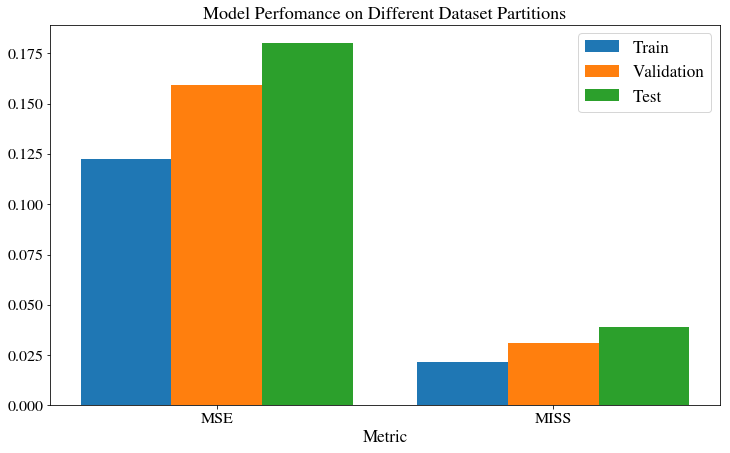

In [107]:
ind = np.arange(2)
width = 0.27

train_metrics = cv_k50_results[["cv_MSE_train", "cv_miss_train"]]
validate_metrics = cv_k50_results[["cv_MSE_test", "cv_miss_test"]]
test_metrics = [MSE_test, 1-accuracy_test]

# convert to vector because of plt.bar
train_metrics = np.array(train_metrics)[0]
validate_metrics = np.array(validate_metrics)[0]

rects_train = plt.bar(ind, train_metrics, width, align="center")
rects_validate = plt.bar(ind + width, validate_metrics, width, align="center")
rects_test = plt.bar(ind + width*2, test_metrics, width, align="center")

plt.title("Model Perfomance on Different Dataset Partitions")
plt.xlabel('Metric')
plt.xticks(ind+width, ["MSE", "MISS"])
plt.legend((rects_train[0], rects_validate[0], rects_test[0]), ('Train', 'Validation', 'Test'));